# Python for Trading

This document explains how to import stocks' data from Yahoo, Choose the best market to invest in, caculate your portfolio, and other **intersting** things.<br>

In [48]:
import yfinance
# from yahoofinancials import YahooFinancials
import mplfinance as mpf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn  as sns
from plotly import express as px
import datetime as dt
import os
# -----------------------------------------
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
#-------------------------------------------
sns.set()

# *Downloading Data from* <font color='purple'>Yahoo!</font>
1- Using `yf.download` <br>
2- Using `yfinance.Ticker(['list of stock names']).history('args')`<br>
3- Using `pandas_data_reader`<br>

[List of SP500 Companies](https://www.liberatedstocktrader.com/sp-500-companies/)

*Define stock names, Start date, End date, and interval*

In [49]:
stocknames = ['MSFT','AAPL', 'SPY']
startdate = '2019-01-01'
enddate =   dt.datetime.now().date()
# enddate = '2019-12-31'
interval = '1d'

downloading data using Using yf.download

In [50]:
# for stock in stocknames:
#     df = yfinance.download('SPY', interval= interval, period='max')
#     df.to_csv('{}.csv'.format('SPY'))

downloading data using Using yfinance.Ticker(['list of stock names']).history('args')

In [51]:
# for stock in stocknames:
#     df = yfinance.Ticker(stock).history(start = startdate, end = enddate, interval=interval, auto_adjust=True)
#     # yfinance.Ticker(stocknames).history(period='max', interval=interval, auto_adjust=True)
#     df.to_csv('{}.csv'.format(stock))

downloading data using Using pandas_datareader

In [52]:
# for stock in stocknames:
#     from pandas_datareader import data
#     df= data.DataReader(stock, 'yahoo', startdate, enddate)
#     df.to_csv('{}.csv'.format(stock))

In [53]:
from pandas_datareader import data
data.get_data_yahoo(stocknames,
                               start = startdate,
                               end = enddate)

--------------------------------------------------------------
--------------------------------------------------------------

In [54]:
# Functions
def appending(cols=[], startdate = '', enddate = ''):
    '''append stocks data into one file and then select the Adj Close column'''
    global df
    dates = pd.date_range(start= startdate, end= enddate)
    df = pd.DataFrame(index= dates)
    for stock in stocknames:
        df_symbols = pd.read_csv(os.path.join('{}.csv'.format(stock)), index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_symbols = df_symbols.rename(columns={'Adj Close' : stock})
        df = df.join(df_symbols)
        df = df.loc[dates]
    df = df.dropna()
    return df

In [55]:
appending(['Date', 'Adj Close'], startdate, enddate)
df.index.names = ['Date']
df.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,97.58,38.28,237.86
2019-01-03,93.99,34.46,232.18
2019-01-04,98.36,35.94,239.96
2019-01-07,98.49,35.86,241.85
2019-01-08,99.20,36.54,244.12


### *Global Statistics:*

In [132]:
df_desc = df.describe().T
df_desc[['count', 'mean', 'std', '50%', 'max']]

,count,mean,std,50%,max
MSFT,252.00,126.85,15.00,131.53,155.66
AAPL,252.00,50.93,8.66,49.64,72.25
SPY,252.00,278.83,15.78,279.14,312.85


### A Quick look at the prices

In [58]:
px.line(data_frame=df, title='Tickers Adj. close prices', width=800, height=300)

We need to observe `the movement stock` (How much the stock went up or down compared to the others), therefore we need to **`Normalize`** the prices of stocks to start with *$1*, to do this we will ***devid the prices of each column by day One***.<br>
$$Norm = df / df.iloc[0,:]$$

In [135]:
df.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,97.58,38.28,237.86
2019-01-03,93.99,34.46,232.18
2019-01-04,98.36,35.94,239.96
2019-01-07,98.49,35.86,241.85
2019-01-08,99.20,36.54,244.12


In [138]:
norm = df / df.iloc[0,:]
norm.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,1.00,1.00,1.00
2019-01-03,0.96,0.90,0.98
2019-01-04,1.01,0.94,1.01
2019-01-07,1.01,0.94,1.02
2019-01-08,1.02,0.95,1.03


Plotting normaliztion using plotly

In [139]:

fig = px.line(norm, x=norm.index, y=['AAPL','SPY', 'MSFT'])
# Edit the layout
fig.update_layout(title='Stock movement observation by normalizing Adj close prices, (Daily Cumulative Return)',
                   xaxis_title='Date',
                   yaxis_title='Normalized price')
fig.show();

Plotting normaliztion using pandas plot function

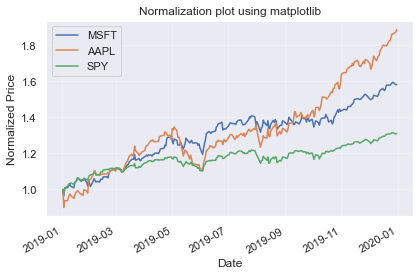

In [61]:
norm.plot()
plt.grid(alpha=0.25)
plt.title('Normalization plot using matplotlib')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.tight_layout();

### *Rolling Statistics*

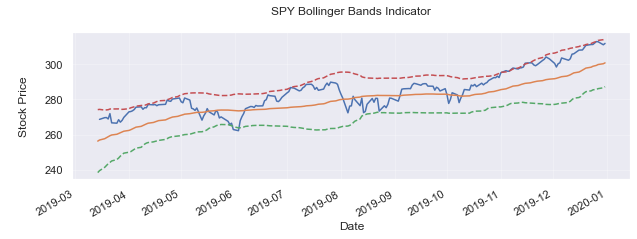

In [62]:
rollingmean = df.SPY.rolling(50).mean()
rollingstd = df.SPY.rolling(50).std()
lowerbound = rollingmean - (2 * rollingstd)
upperbound = rollingmean + ( 2 * rollingstd)
fig, ax = plt.subplots(figsize=(10,3))
df.iloc[50:]['SPY'].plot(ax=ax)
ax.set_title('SPY Bollinger Bands Indicator\n')
ax.set_xlabel('Date')
ax.set_ylabel('\nStock Price\n')
rollingmean.plot(ax=ax, linestyle='-')
lowerbound.plot(ax=ax, linestyle='--')
upperbound.plot(ax=ax, linestyle='--')
plt.grid(alpha=0.25);

# - Metrics
> * Daily Returns 
> * Cummulative Returns
> * Sharpe Ratio

### <font color='orange'>Daily returns ratio:</font> is how much did the price go up or down on a particular day 
$$Daily Returns (t) = (price[t] / price[t-1]) - 1$$

In [63]:
daily_returns = (df / df.shift(1)) -1
daily_returns.iloc[0,:] = 0
daily_returns.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,0.00,0.00,0.00
2019-01-03,-0.04,-0.10,-0.02
2019-01-04,0.05,0.04,0.03
2019-01-07,0.00,-0.00,0.01
2019-01-08,0.01,0.02,0.01


* You can get the same result by using `pct_change` function

In [64]:
daily_returns = df.pct_change()
daily_returns.iloc[0,:] = 0
daily_returns.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,0.00,0.00,0.00
2019-01-03,-0.04,-0.10,-0.02
2019-01-04,0.05,0.04,0.03
2019-01-07,0.00,-0.00,0.01
2019-01-08,0.01,0.02,0.01


*Daily Returns Global Statistics*

In [65]:
daily_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
MSFT,252.00,0.00,0.01,-0.04,-0.00,0.00,0.01,0.05
AAPL,252.00,0.00,0.02,-0.10,-0.00,0.00,0.01,0.07
SPY,252.00,0.00,0.01,-0.03,-0.00,0.00,0.01,0.03


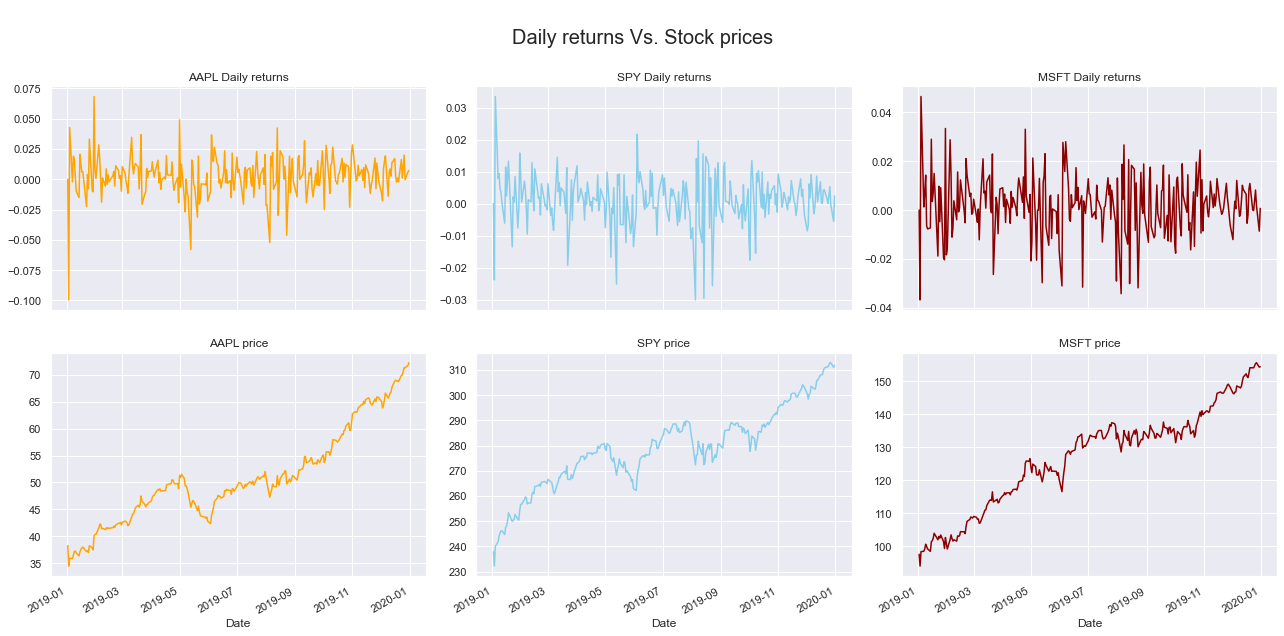

In [66]:
fig, ax = plt.subplots(2,3,figsize=(18,9), sharex=True)

daily_returns.AAPL.plot(ax=ax[0][0], color='orange')
ax[0][0].set_title('\nAAPL Daily returns')

daily_returns.SPY.plot(ax=ax[0][1], color='skyblue')
ax[0][1].set_title('\nSPY Daily returns')

daily_returns.MSFT.plot(ax=ax[0][2], color='darkred')
ax[0][2].set_title('\nMSFT Daily returns')

df.AAPL.plot(kind='line', ax=ax[1][0], color='orange')
ax[1][0].set_title('\nAAPL price')

df.SPY.plot(ax=ax[1][1], color='skyblue')
ax[1][1].set_title('\nSPY price')

df.MSFT.plot(ax=ax[1][2], color='darkred')
ax[1][2].set_title('\nMSFT price')
fig.suptitle('\nDaily returns Vs. Stock prices', fontsize=20)
plt.tight_layout();

*Daily return statistics*<br>
1- **The Mean** <br>
2- **Standard Deviation** <br>
3- **Kurtosis:** tell us about the `tails of the normal distribution`. the measure of Kurtosis tells us how much `different` our histogram is from that traditional normal distribution.<br><br>
<font color='skyblue'>Types of Kurtosis:</font> <br>

> **Fat tails (value is positive)**: means that there are occasional and more frequent that would happen if we had a regular Gaussin distribution. There are frequently large excursions more frequently than if this was a normal distribution. (More occurrences out in the tails than would be expected if it were a normal distribution).<br><br>

> **Skinny tails (value is negative)**: (Many fewer occurrences out on the tails than would be expected if it were a normal distribution).<br><br>

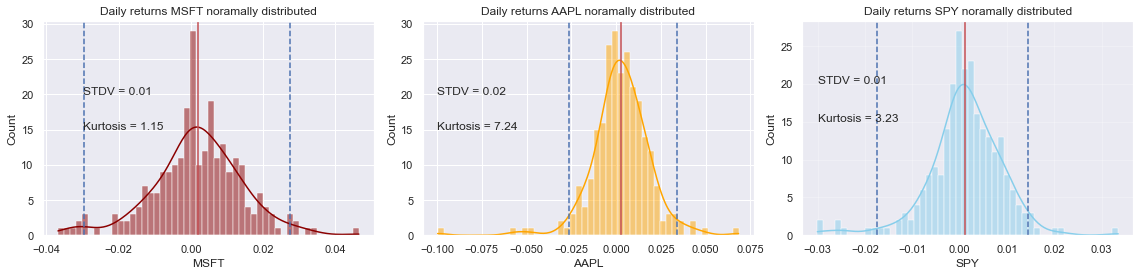

In [67]:

fig, ax = plt.subplots(1,3, figsize=(16,4))

# sns.displot(daily_returns)
sns.histplot(daily_returns.MSFT,bins=50, kde=True, color='darkred',  ax=ax[0])
ax[0].set_title('Daily returns MSFT noramally distributed')
# ax[0].axvline(daily_returns.MSFT.std())
# ax[0].axvline(- daily_returns.MSFT.std())
ax[0].axvline(np.percentile(daily_returns.MSFT,97.5), linestyle='--')
ax[0].axvline(np.percentile(daily_returns.MSFT,2.5), linestyle='--')
ax[0].axvline(daily_returns.MSFT.mean(), c='r')
ax[0].text(-0.03, 20, 'STDV = {}'.format(round(daily_returns.MSFT.std(),2)))
ax[0].text(-0.03, 15, 'Kurtosis = {}'.format(round(daily_returns.MSFT.kurtosis(),2)))

sns.histplot(daily_returns.AAPL, bins=50, kde=True, color='orange',  ax=ax[1])
ax[1].set_title('Daily returns AAPL noramally distributed')
# ax[1].axvline(daily_returns.AAPL.std())
# ax[1].axvline(- daily_returns.AAPL.std())
ax[1].axvline(daily_returns.AAPL.mean(), c='r')
ax[1].axvline(np.percentile(daily_returns.AAPL,97.5), linestyle='--')
ax[1].axvline(np.percentile(daily_returns.AAPL,2.5), linestyle='--')
ax[1].text(-0.1, 20, 'STDV = {}'.format(round(daily_returns.AAPL.std(),2)))
ax[1].text(-0.1, 15, 'Kurtosis = {}'.format(round(daily_returns.AAPL.kurtosis(),2)))

sns.histplot(daily_returns.SPY, bins=50, kde=True, color='skyblue',  ax=ax[2])
ax[2].set_title('Daily returns SPY noramally distributed')
# ax[2].axvline(daily_returns.SPY.std())
# ax[2].axvline(- daily_returns.SPY.std())
ax[2].axvline(daily_returns.SPY.mean(), c='r')
ax[2].axvline(np.percentile(daily_returns.SPY,97.5), linestyle='--')
ax[2].axvline(np.percentile(daily_returns.SPY,2.5), linestyle='--')
ax[2].text(-0.03, 20, 'STDV = {}'.format(round(daily_returns.SPY.std(),2)))
ax[2].text(-0.03, 15, 'Kurtosis = {}'.format(round(daily_returns.SPY.kurtosis(),2)))

plt.grid(alpha=0.25)
plt.tight_layout();

Based on Kurtosis results: More occurrences out in the tails than would be expected if it were a normal distribution.

---------------------------------------------------------------------

##### We are considering two general properties indicated by the histogram for each stock: **Return and volatility (or risk)**.

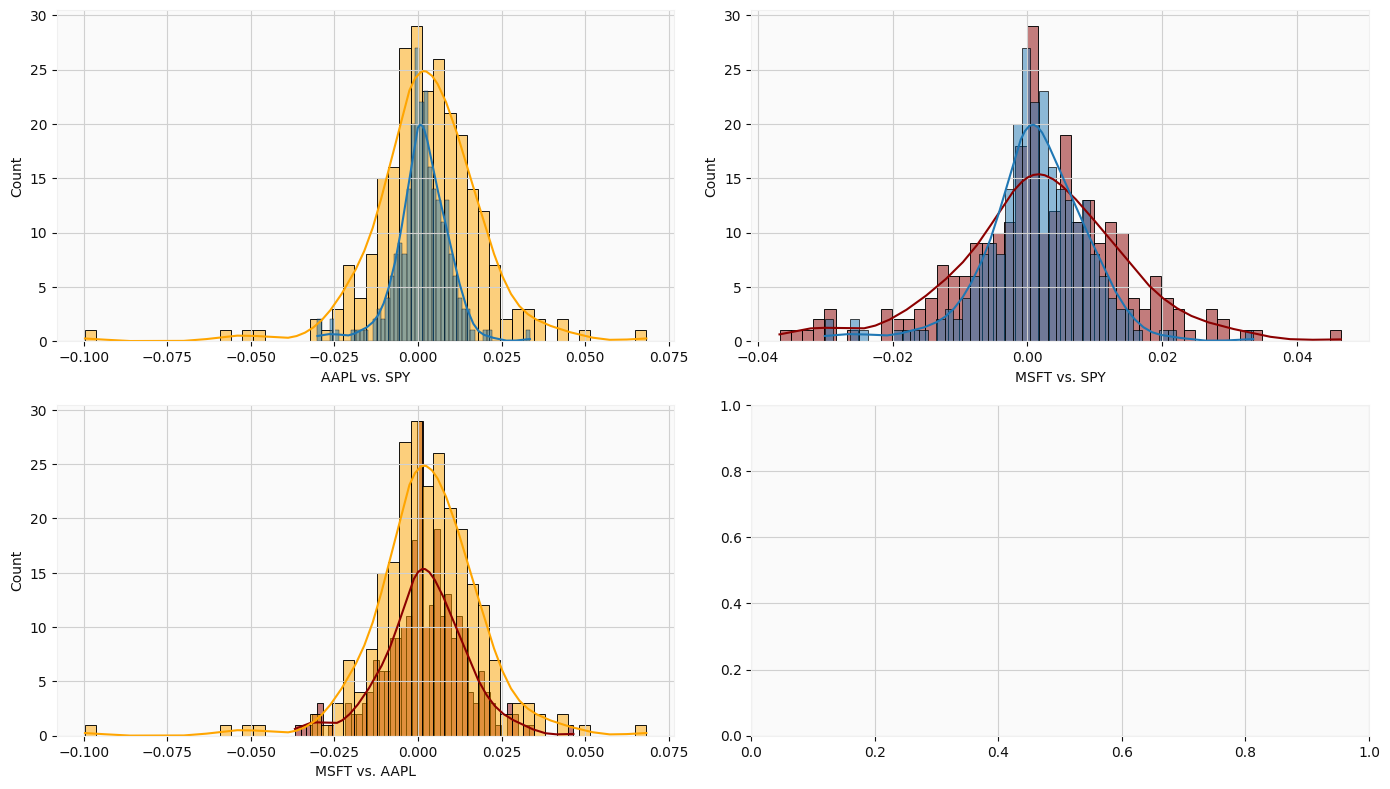

In [114]:
fig, ax = plt.subplots(2,2, figsize=(14,8))
sns.histplot(daily_returns.AAPL, bins=50, color='orange', ax=ax[0,0], kde=True)
# ax[0,0].axvline(2 * daily_returns.AAPL.std(), color='orange')
# ax[0,0].axvline(-2 * daily_returns.AAPL.std(), color='orange')
sns.histplot(daily_returns.SPY, bins=50, ax=ax[0,0], kde=True)
ax[0,0].set_xlabel('AAPL vs. SPY')
# ax[0,0].axvline(2 * daily_returns.SPY.std(), color='blue')
# ax[0,0].axvline(-2 * daily_returns.SPYstd(), color='blue')
sns.histplot(daily_returns.MSFT, bins=50, color='darkred', ax=ax[0,1], kde=True)
sns.histplot(daily_returns.SPY,  bins=50, ax=ax[0,1], kde=True)
ax[0,1].set_xlabel('MSFT vs. SPY')
sns.histplot(daily_returns.MSFT, bins=50, color='darkred', ax=ax[1,0], kde=True)
sns.histplot(daily_returns.AAPL, bins=50, ax=ax[1,0], color='orange', kde=True, alpha=0.5)
ax[1,0].set_xlabel('MSFT vs. AAPL')
plt.tight_layout();

1. `SPY` is lower return and lower volatiliy than `AAPL` <br>
2. `SPY` is higher return and lower volatility than `MSFT` <br>
3. `MSFT` is lower return and lower volatility than `AAPL`

---------------------------------------------

## Correlations

[[1.         0.74173879]
 [0.74173879 1.        ]]


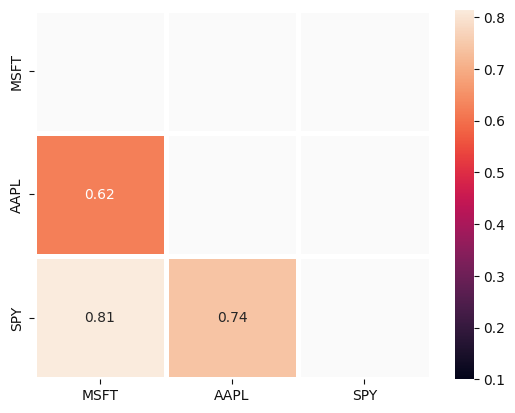

In [115]:
print(np.corrcoef(daily_returns.SPY, daily_returns.AAPL))
 #take the bottom triangle since it repeats itself 
mask = np.zeros_like(daily_returns.corr())
mask[np.triu_indices_from(mask)] = True
mask
sns.heatmap(daily_returns.corr(), annot=True, vmin=0.1, mask=mask, linewidths=2.5);

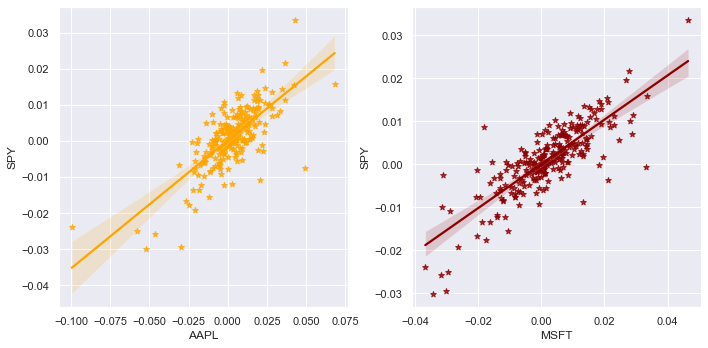

In [70]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.regplot(data=daily_returns, x=daily_returns.AAPL, y=daily_returns.SPY ,scatter=True, marker='*', ax=ax[0], color = 'orange')
sns.regplot(data=daily_returns, x=daily_returns.MSFT, y=daily_returns.SPY ,scatter=True, marker='*', ax=ax[1], color='darkred')
plt.tight_layout();

*Cooficient Correlation and Pvalue using SciPy:*

In [ ]:
coff, pval = stats.pearsonr(daily_returns.AAPL, daily_returns.SPY)
print('Coffcorr AAPL/SPY= {:,.0f}'.format(coff), 'Pval={}'.format(pval))
coff, pval = stats.pearsonr(daily_returns.MSFT, daily_returns.SPY)
print('Coffcorr MSFT/SPY= {:,.0f}'.format(coff), 'Pval={}'.format(pval))

Coffcorr AAPL/SPY= 1 Pval=2.891763760725586e-45
Coffcorr MSFT/SPY= 1 Pval=4.858933790236295e-61


β (Beta = Slop): is how reactive is the market to the stock.<br>
α (Alpha = Intercept): is how well the market performs with respect of stock

$$ŷ = βx + α$$
$$ŷ = Beta * x + Alpha$$
$$ŷ = Slop * x + Intercept$$

*Cooficient Correlation and Pvalue using Numpy:*

In [71]:
beta_SPY_AAPL, alpha_SPY_AAPL = np.polyfit(daily_returns.AAPL, daily_returns.SPY,1)
print('beta AAPL/SPY= {}'.format(beta_SPY_AAPL), 'alpha AAPL/SPY= {}'.format(alpha_SPY_AAPL))
beta_SPY_MSFT, alpha_SPY_MSFT = np.polyfit(daily_returns.MSFT, daily_returns.SPY,1)
print('beta MSFT/SPY= {}'.format(beta_SPY_MSFT), 'alpha MSFT/SPY= {}'.format(alpha_SPY_MSFT))
# daily_returns.plot(kind='scatter', x= 'AAPL', y='SPY')
# plt.plot(daily_returns.AAPL, beta_SPY * daily_returns.AAPL + alpha_SPY, '-', c='r');

beta AAPL/SPY= 0.3550280452645373 alpha AAPL/SPY= 0.000161368913903557
beta MSFT/SPY= 0.5141528818303688 alpha MSFT/SPY= 0.00012837633572954478


When AAPL price goes up 1%, SPY goes up by 0.36%<br>
When MSFT price goes up 1%, SPY goes up by 0.5%

In [73]:
slop, intercept, r, p, std_err = stats.linregress(daily_returns.AAPL, daily_returns.SPY)
print('AAPL/SPY\n','beta (slop) = ', slop, '\nalpha (Intercept) = ', intercept, '\nCoffCorr = ', r, '\nPvalue = ', p)
#-----------------------------------------------------
print('-' * 50)
slop, intercept, r, p, std_err = stats.linregress(daily_returns.MSFT, daily_returns.SPY)
print('MSFT/SPY\n','beta (slop) = ', slop, '\nalpha (Intercept) = ', intercept, '\nCoffCorr = ', r, '\nPvalue = ', p)

AAPL/SPY
 beta (slop) =  0.35502804526453746 
alpha (Intercept) =  0.00016136891390355673 
CoffCorr =  0.7417387886251363 
Pvalue =  2.891763760725684e-45
--------------------------------------------------
MSFT/SPY
 beta (slop) =  0.5141528818303691 
alpha (Intercept) =  0.00012837633572954413 
CoffCorr =  0.8144690179585858 
Pvalue =  4.858933790235251e-61


*Cooficient Correlation, Pvalue, and Beta using Stats model (Simple Linear Regression):*

In [ ]:
ml = daily_returns.copy()
ml['intercept'] = 1
lm = sm.OLS(ml.SPY, ml[['intercept', 'AAPL']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     305.8
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           2.89e-45
Time:                        01:15:43   Log-Likelihood:                 964.09
No. Observations:                 252   AIC:                            -1924.
Df Residuals:                     250   BIC:                            -1917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.477      0.633      -0.001       0.001
AAPL           0.3550      0.020     17.486      0.000       0.315       0.395
==============================================================================
Omnibus:                       36.297   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.010
Skew:                          -0.620   Prob(JB):                     1.92e-22
Kurtosis:                       5.826   Cond. No.                         60.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- When `AAPL` price goes up 1%, `SPY` goes up by 0.36%<br>
- 55% of the variability in `SPY` price can be explained by `AAPL` price.

In [119]:
ml = daily_returns.copy()
ml['intercept'] = 1
lm = sm.OLS(ml.SPY, ml[['intercept', 'MSFT']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     492.6
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           4.86e-61
Time:                        01:43:32   Log-Likelihood:                 1000.6
No. Observations:                 252   AIC:                            -1997.
Df Residuals:                     250   BIC:                            -1990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.440      0.661      -0.000       0.001
MSFT           0.5142      0.023     22.195      0.000       0.469       0.560
==============================================================================
Omnibus:                       23.198   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.113
Skew:                          -0.409   Prob(JB):                     1.08e-12
Kurtosis:                       5.140   Cond. No.                         80.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- When `MSFT` price goes up 1%, `SPY` goes up by 0.51%<br>
- 66% of the variability in `SPY` price can be explained by `MSFT` price.

------------------------------------------

### <font color='orange'>Cumulative returns ratio:</font> is the **Profit/Loss** ratio of the stock on a particular period.
**$$ CR (t) = (price[t] / price[0]) - 1$$**
### <center>OR</center>
**$$ CR (t) = (price[t] - price[0]) price[0]$$**

In [74]:
print('Cumulative return of MSFT is: {} %'.format(round(((df.iloc[-1]['MSFT'] / df.iloc[0]['MSFT']) - 1) * 100),2))
print('Cumulative return of AAPL is: {} %'.format(round(((df.iloc[-1]['AAPL'] / df.iloc[0]['AAPL']) - 1) * 100),2))
print('Cumulative return of SPY is: {} %'.format(round(((df.iloc[-1]['SPY'] / df.iloc[0]['SPY']) - 1) * 100),2))

Cumulative return of MSFT is: 58 %
Cumulative return of AAPL is: 89 %
Cumulative return of SPY is: 31 %


`MSFT` stock price increased almost 58% during the period while `AAPL` stock price increased 89%.<br> 
During the same period the `SPY` increased  by 31%.<br>

---------------------------------------------

### <font color='orange'>Daily Portfolio value:</font> Calculating overall value of portfolio Day by Day
*Given:*<br>
    - **start value (start_val):** Portfolio Value (the amount of investment)<br>
    - **start date and end date**<br>
    - **allocations (allocs):** allocating the portfolio value on the stocks<br>
    - **Position value (pos_val):** at each day, that's how much that position is worth<br>
    - **Portfolio value (portfolio_daily_returns):** reflects the value each day for our total portfolio
* normailze the prices $(prices / prices[0])$
* allocs = $norm * allocs$
* pos_val = $allocs * StartVal$
* portfolio_daily_returns = pos_val.sum(axis=1)<br>

*Portfolio Statistics*
* Portfolio Values
* Daily return of portfolio
* Mean and STDV
* Sharpe Ratio

# Portfolio 1

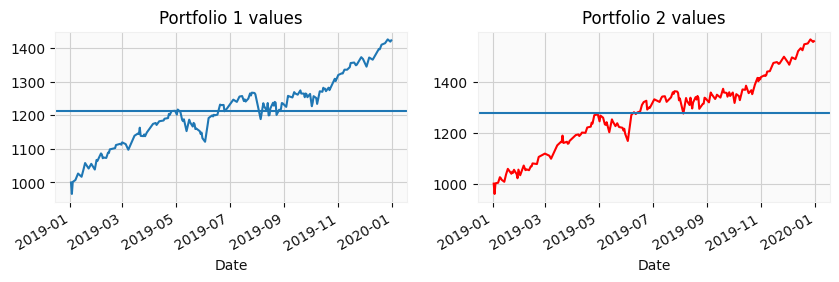

In [175]:
def portval (allocations = [], start_value = 0):
    
    allocs = norm.copy() * allocations
    pos_val = allocs * 1000
    port_val = pos_val.sum(axis=1)
    return port_val

# assume our start value = $ 1000
# allocation : 30% AAPL, 30% MSFT, 40% SPY
fig, ax = plt.subplots(1,2,figsize=(10,2.5))

port_val = portval([0.2,0.1,0.7], 1000)
port_val.plot(ax=ax[0])
ax[0].axhline(np.mean(port_val))
ax[0].set_title('Portfolio 1 values')

port_val2 = portval([0.7,0.1,0.2], 1000)
port_val2.plot(ax=ax[1], color='red')
ax[1].axhline(np.mean(port_val2))
ax[1].set_title('Portfolio 2 values');

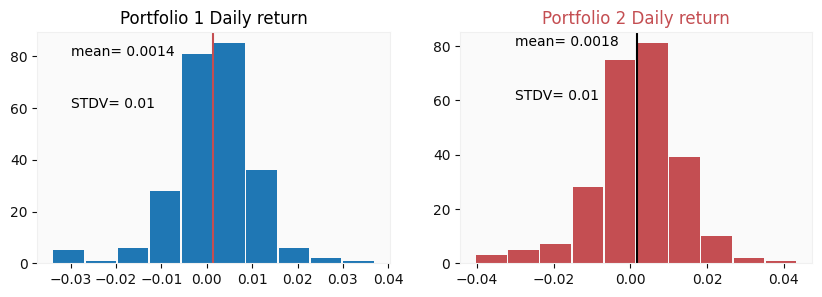

In [184]:
portfolio_daily_returns = (port_val / port_val.shift(1)) - 1
portfolio_daily_returns = portfolio_daily_returns.iloc[1:]

portfolio_daily_returns2 = (port_val2 / port_val2.shift(1)) - 1
portfolio_daily_returns2 = portfolio_daily_returns2.iloc[1:]

fig, ax = plt.subplots(1,2,figsize=(10,2.5))

portfolio_daily_returns.hist(figsize=(5,3), grid=False, rwidth=0.95, ax=ax[0])
ax[0].axvline(np.mean(portfolio_daily_returns), c='r')
ax[0].text(-0.03, 80, 'mean= {}'.format(round(np.mean(portfolio_daily_returns),4)))
ax[0].text(-0.03, 60, 'STDV= {}'.format(round(np.std(portfolio_daily_returns),2)))
ax[0].set_title('Portfolio 1 Daily return')

portfolio_daily_returns2.hist(figsize=(10,3), grid=False, rwidth=0.95, color='r', ax=ax[1])
ax[1].axvline(np.mean(portfolio_daily_returns2), c='black')
ax[1].text(-0.03, 80, 'mean= {}'.format(round(np.mean(portfolio_daily_returns2),4)))
ax[1].text(-0.03, 60, 'STDV= {}'.format(round(np.std(portfolio_daily_returns2),2)))
ax[1].set_title('Portfolio 2 Daily return', c='r');

*Cumulative Return of DPV*

In [177]:
cum_return = ((port_val.iloc[-1] / port_val.iloc[0]) -1) * 100 
print('Cumulative return of Portfolio is {} %'.format(round(cum_return),2))
cum_return2 = ((port_val2.iloc[-1] / port_val2.iloc[0]) -1) * 100 
print('Cumulative return of Portfolio 2 is {} %'.format(round(cum_return2),2))

Cumulative return of Portfolio is 42 %
Cumulative return of Portfolio 2 is 56 %


*Mean and STDV of DPV*

In [178]:
print('Mean of Portfolio 1 (Return) = {}'.format(round(np.mean(portfolio_daily_returns) * 100,2)),'%', '  ' , 'Standard Deviation 1 (Risk) = {}'.format(round(np.std(portfolio_daily_returns) * 100,2)),'%')
print('Mean of Portfolio 2 (Return) = {}'.format(round(np.mean(portfolio_daily_returns2) * 100,2)),'%', '   ' , 'Standard Deviation 2 (Risk) = {}'.format(round(np.std(portfolio_daily_returns2) * 100,2)),'%')

Mean of Portfolio 1 (Return) = 0.14 %    Standard Deviation 1 (Risk) = 0.9 %
Mean of Portfolio 2 (Return) = 0.18 %     Standard Deviation 2 (Risk) = 1.13 %


In [179]:
print('Mean od Portfolio 1 (Return) = {}'.format(round(np.mean(port_val.iloc[1:]),2)), ' ' , 'Standard Deviation  1  (Risk) = {}'.format(round(np.std(port_val.iloc[1:]),2)))
print('Mean od Portfolio 2 (Return) = {}'.format(round(np.mean(port_val2.iloc[1:]),2)), '  ' ,'Standard Deviation  2  (Risk) = {}'.format(round(np.std(port_val2.iloc[1:]),2)))

Mean od Portfolio 1 (Return) = 1214.48   Standard Deviation  1  (Risk) = 97.17
Mean od Portfolio 2 (Return) = 1278.6    Standard Deviation  2  (Risk) = 140.49


We can notice clearly that the retrun of portfolio 2 is higher than portfolio 1 *`(0.2% P2 vs. 0.16% P1)`*, but on the other side, the risk (STDV) is also higher, and we already expected this result above

<font color='skyblue'>SHARPE RATIO</font>: <br>is a metric that evaluates risk and returns together in order to help investors in the selection of such investment that generates higher returns for the optimal risk taken.<br><br>
*<font color='red'>For comparison:*</font> The Higher the sharpe ratio the better <br>
$$Sharpe Ratio = \frac{μ_{PDR} - RFR} {σ_{PDR}}$$
*The Sharpe ratio* can be annualized by multiplying the above ratio by the `square root of 252` as shown below.<br>
$$Sharpe Ratio =\sqrt{252} * \frac{μ_{PDR} - RFR} {σ_{PDR}}$$

Resources:<br>
[efinancemanagement](https://efinancemanagement.com/calculator/sharpe-ratio-2#:~:text=Sharpe%20ratio%20calculator%20is%20an%20online%20tool%20for,asset%20helps%20in%20generating%20higher%20returns%20or%20not.)<br>
[investopedia](https://www.investopedia.com/terms/s/sharperatio.asp)

In [180]:
SR = round( np.sqrt(252) * (np.mean(portfolio_daily_returns))/ np.std(portfolio_daily_returns),2)
print('Sharpe Ratio 1 = {}%'.format(SR),)
SR2 = round( np.sqrt(252) * (np.mean(portfolio_daily_returns2))/ np.std(portfolio_daily_returns2),2)
print('Sharpe Ratio 2 = {}%'.format(SR2))

Sharpe Ratio 1 = 2.55%
Sharpe Ratio 2 = 2.58%


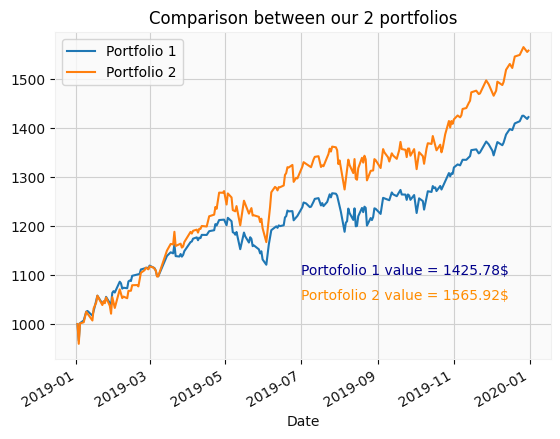

In [192]:
fig, ax = plt.subplots()
port_val.plot(ax=ax)
port_val2.plot(ax=ax)
plt.legend(['Portfolio 1', 'Portfolio 2'])
plt.title('Comparison between our 2 portfolios')
plt.text('2019-07', 1100,'Portofolio 1 value = {}$'.format(round(port_val.max(),2)), color='darkblue')
plt.text('2019-07', 1050,'Portofolio 2 value = {}$'.format(round(port_val2.max(),2)), color='darkorange');

confirming the above result, we can see here the Sharpe Ratio of Portfolio 2 is higher than portfolio 1

-------------------------------------------

# CANDLES CHART

In [182]:
mpf.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

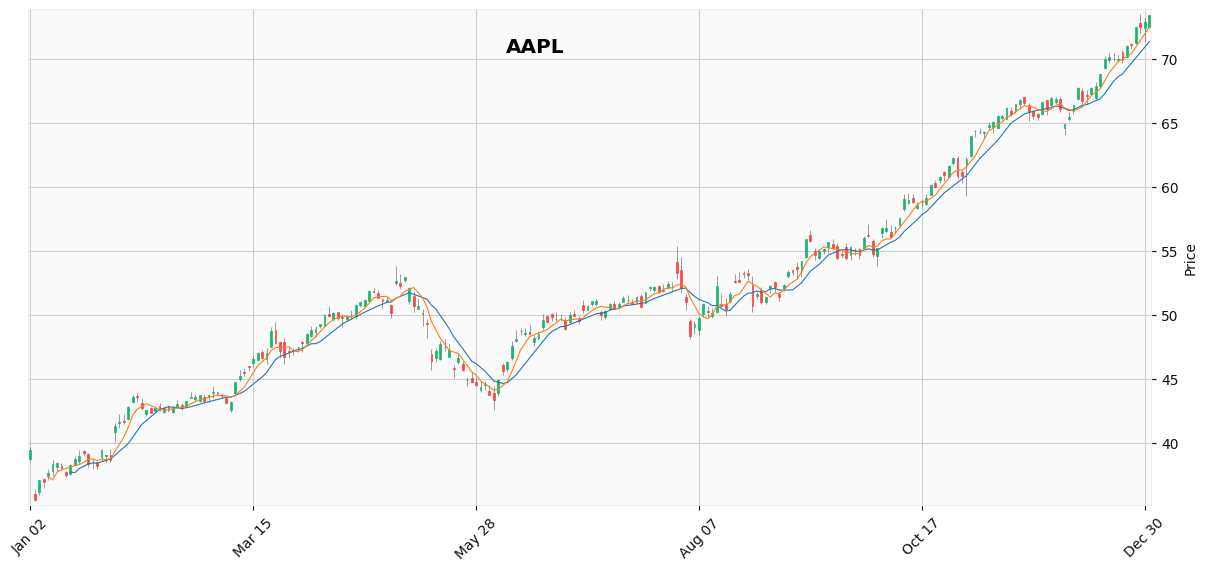

In [183]:
AAPL = pd.read_csv('AAPL.csv', index_col=0, parse_dates=True)
mask = (AAPL.index >= '2019-01-01') & (AAPL.index <= '2019-12-31')
AAPL = AAPL.loc[mask]
mpf.plot(AAPL, type = 'candle', volume=False, mav= (10,5), title='AAPL',tight_layout=True, figratio=(18,8), style='yahoo')